In [ ]:
import numpy as np 
import pandas as pd 
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.colors import to_hex
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import scipy as sp
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
from module.utils import dendrogram_clustering
from module.CenVec.vectorise import get_centrality_df, get_shell_graph
from module.Ceval.dendrogram_eval import get_clustering_stats

## C elegans connectome:

In [5]:
ce_meta = pd.read_csv('../data/celegans/ce_meta.csv', index_col=0)
ce_all_edges = pd.read_csv('../data/celegans/ce_all_edges.csv')
ce_chem_edges = pd.read_csv('../data/celegans/ce_chem_edges.csv')

### vectors:

In [24]:
def get_centrality_df_2(edges, weighted=False): 
    '''from a df of edges, get the closeness, betweenness and eigenvector centrality'''

    g = nx.DiGraph()
    
    if weighted:
        slice_string = ['pre', 'post', 'attr']
        w_str = 'weight'
        iw_str = 'inv_weight'
    if not weighted:
        slice_string = ['pre', 'post']
        w_str = None
        iw_str = None


    g.add_edges_from(edges[slice_string].to_numpy())
    
    undirected_g = get_shell_graph(g)
    in_ccent = nx.closeness_centrality(g, distance=iw_str) # to find paths from the target node
    out_ccent = nx.closeness_centrality(g.reverse(), distance=iw_str) # to find paths from the target node
    out_deg_cent = nx.out_degree_centrality(g)
    in_deg_cent = nx.in_degree_centrality(g)
    deg_cent = nx.degree_centrality(g)
    bcent = nx.betweenness_centrality(g, weight=iw_str)
    u_bcent = nx.betweenness_centrality(undirected_g, weight=iw_str)
    out_ecent = nx.eigenvector_centrality(g.reverse(), weight=w_str, max_iter=200) # to find eigenvectors of matrix for out-edges
    in_ecent = nx.eigenvector_centrality(g, weight=w_str, max_iter=200) # to find eigenvectors of matrix for out-edges
    
    pagerank = nx.pagerank(g, weight=w_str)

    percolation = nx.percolation_centrality(g, weight=w_str)

    # out_voterank = nx.voterank(g)
    # in_voterank = nx.voterank(g.reverse())

    laplacian = nx.laplacian_centrality(g, weight=w_str)
    # print(len(laplacian))
    # print(len(out_voterank))
    # print(len(in_voterank))
    # print(len(percolation))
    # print(len(pagerank))

    centralities = {'closeness_in':in_ccent,'closeness_out':out_ccent,\
                    'betweenness':bcent, 'eigenvector_in':in_ecent, 'eigenvector_out':out_ecent,\
                    'degree':deg_cent, 'in_degree':in_deg_cent, 'out_degree':out_deg_cent,\
                    'u_betweenness':u_bcent, 'pagerank':pagerank, 'percolation':percolation,\
                   'laplacian':laplacian} #  'out_voterank':out_voterank, 'in_voterank':in_voterank,
    if weighted:
        strength = dict(nx.degree(g, weight='weight'))
        in_strength = dict(g.in_degree(weight='weight'))
        out_strength = dict(g.out_degree(weight='weight'))
        centralities['strength'] = strength
        centralities['in_strength'] = in_strength
        centralities['out_strength'] = out_strength
    c_df = pd.DataFrame(centralities)
    return c_df

In [17]:
ce_chem_edges['attr'] = ce_chem_edges.weight.apply(lambda x: {'weight':x, 'inv_weight':1/x})
chem_centralities = get_centrality_df_2(edges=ce_chem_edges, weighted=True)
# chem_centralities.to_csv('../data/celegans/processed/chem_centralities.csv')

# rescale these by ranking and taking the log of the ranking 
rank_chem_centralities =chem_centralities.copy(True)

to_rank_cols = rank_chem_centralities.columns
for i in to_rank_cols:
    rank_chem_centralities[i] = np.log(rank_chem_centralities[i].rank(ascending=False, method='average'))


299
299
299


In [23]:
ce_all_edges['attr'] = ce_all_edges.weight.apply(lambda x: {'weight':x, 'inv_weight':1/x})
alledge_centralities = get_centrality_df_2(edges=ce_all_edges, weighted=True)
# alledge_centralities.to_csv('../data/celegans/processed/alledge_centralities.csv')


# rescale these by ranking and taking the log of the ranking 
rank_alledge_centralities =alledge_centralities.copy(True)

to_rank_cols = alledge_centralities.columns

for i in to_rank_cols:
    # rank_alledge_centralities[i] = np.log(rank_alledge_centralities[i].rank(ascending=False, method='average'))
    rank_alledge_centralities[i] = np.log(rank_alledge_centralities[i].rank(ascending=False, method='average'))


299
299
299


In [63]:
df_to_cluster = rank_alledge_centralities#[cents]


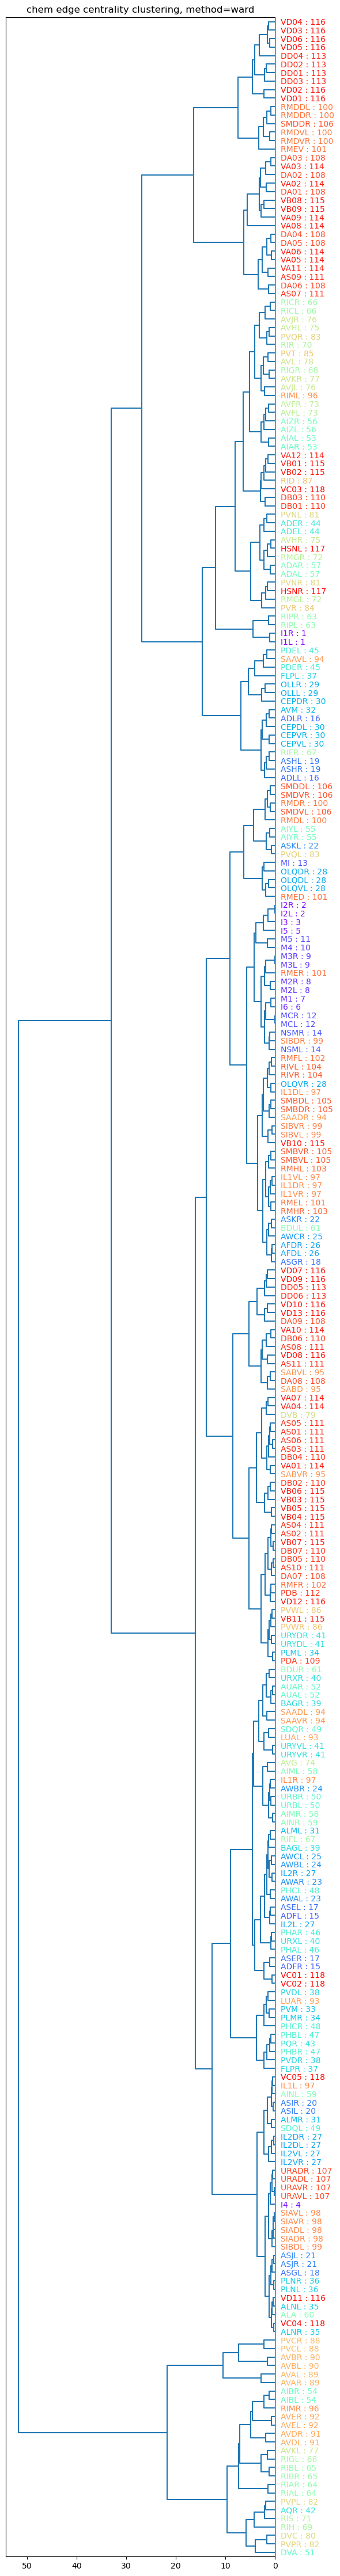

In [26]:
# save=False
exclude = []
cents_for_clustering = set(df_to_cluster.columns) - set(exclude)

df_to_cluster_cent = df_to_cluster.loc[:, list(cents_for_clustering)]
ind_to_id = df_to_cluster_cent.index.values
cell_labelling = 'Cell Class'
which_df = ce_meta.loc[ind_to_id].reset_index()[['Neuron', cell_labelling]].groupby(cell_labelling)['Neuron'].apply(list)
which= which_df.values
ctype_to_id = which_df.to_dict()

id_to_ctype = {}
for i in list(ctype_to_id.keys()):
    ids = ctype_to_id[i] 
    for j in ids:
        id_to_ctype[j] = i
specify_label_dict = id_to_ctype
method='ward'
metric='euclidean'
Z = linkage(df_to_cluster_cent, method=method, metric=metric) ####### linkage
title = f'chem edge centrality clustering, method={method}'
# fname=False

# if save:
#     fname = f'./figs/centrality/embedding/aba_chem_cent_cclass_clustering.pdf'
dendrogram_clustering(Z=Z, labels=ind_to_id, clusters=which, label_dict=specify_label_dict, title_str=f'{title}')
# save=False

## evaluation

In [111]:
df_to_cluster = rank_alledge_centralities#[cents]


In [212]:
# exclude = []
# cents_for_clustering = set(df_to_cluster.columns) - set(exclude)
# cents_for_clustering = ['laplacian', 'in_strength', 'out_strength', 'pagerank', 'eigenvector_in', 'eigenvector_out', 'u_betweenness']
# alledge_centralities[]
cents_for_clustering = ['pagerank', 'strength', 'degree', 'closeness_in', 'out_degree',\
       'closeness_out', 'out_strength', 'eigenvector_in', 'eigenvector_out',\
       'in_strength', 'laplacian', 'betweenness', 'in_degree', 'u_betweenness',\
       'percolation']

# cents_for_clustering = ['pagerank', 'strength', 'degree',\
#        'eigenvector_in', 'eigenvector_out', \
#        'in_strength', 'in_degree']

df_to_cluster_cent = df_to_cluster.loc[:, list(cents_for_clustering)[:9]]
ind_to_id = df_to_cluster_cent.index.values


vector_df = df_to_cluster_cent

method='ward'
metric = 'euclidean'

dist_func = sp.spatial.distance.pdist 

ind_to_id = vector_df.index.values
Z = linkage(vector_df, method=method, metric=metric) 

fc_total_dict = ce_meta.loc[ind_to_id].reset_index().groupby('Final classification').Neuron.apply(list).to_dict()
fcstats_df = get_clustering_stats(Z=Z, ctype_to_id=fc_total_dict, ind_to_id=ind_to_id)
fcstats_df['av_size'] = fcstats_df['m_p']/fcstats_df['n_p']
fcstats_df['coverage'] = fcstats_df['m_p']/(fcstats_df['s_p'] + fcstats_df['m_p'])


In [213]:
fcstats_df.m_p.sum() / fcstats_df.len.sum()

np.float64(0.822742474916388)

In [214]:
fcstats_df.pms.mean()

np.float64(0.2942532017293417)

## LDA:


In [140]:
X = df_to_cluster.to_numpy()
y = ce_meta.loc[ind_to_id]['Final classification'].values

In [144]:
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

In [ ]:
X_lda

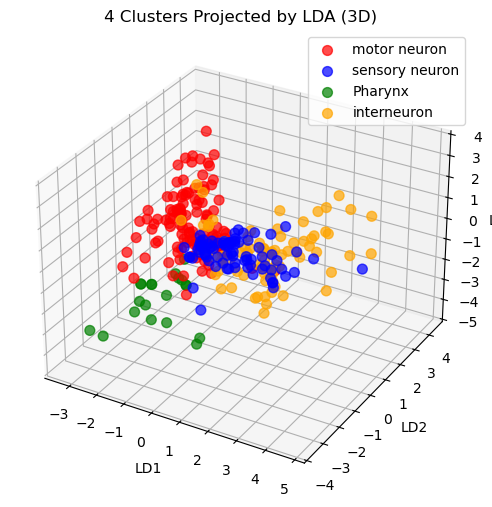

In [171]:
# --- 3D plot ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'b', 'g', 'orange']
labels = list(set(y))

for i, color in enumerate(colors):
    ax.scatter(X_lda[y==labels[i], 0], X_lda[y==labels[i], 1], X_lda[y==labels[i], 2], 
               c=color, label=labels[i], s=50, alpha=0.7)

ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
ax.set_zlabel('LD3')
ax.set_title('4 Clusters Projected by LDA (3D)')
ax.legend()
plt.show()

In [149]:
# The directions in the original feature space:
print("Shape of components:", lda.scalings_.shape)  # (n_features, n_components)
lda_directions = lda.scalings_

Shape of components: (15, 3)


In [150]:
feature_importance = np.sum(np.abs(lda_directions), axis=1)

In [151]:
# rank features
ranking = np.argsort(feature_importance)[::-1]  # descending

In [152]:
ranking

array([ 9, 12,  5,  0,  7,  1, 14,  3,  4, 13, 11,  2,  6,  8, 10])

In [154]:
df_to_cluster.columns[ranking]

Index(['pagerank', 'strength', 'degree', 'closeness_in', 'out_degree',
       'closeness_out', 'out_strength', 'eigenvector_in', 'eigenvector_out',
       'in_strength', 'laplacian', 'betweenness', 'in_degree', 'u_betweenness',
       'percolation'],
      dtype='object')

In [148]:
print("Explained discriminative power:", lda.explained_variance_ratio_)

Explained discriminative power: [0.5606953  0.25157264 0.18773205]


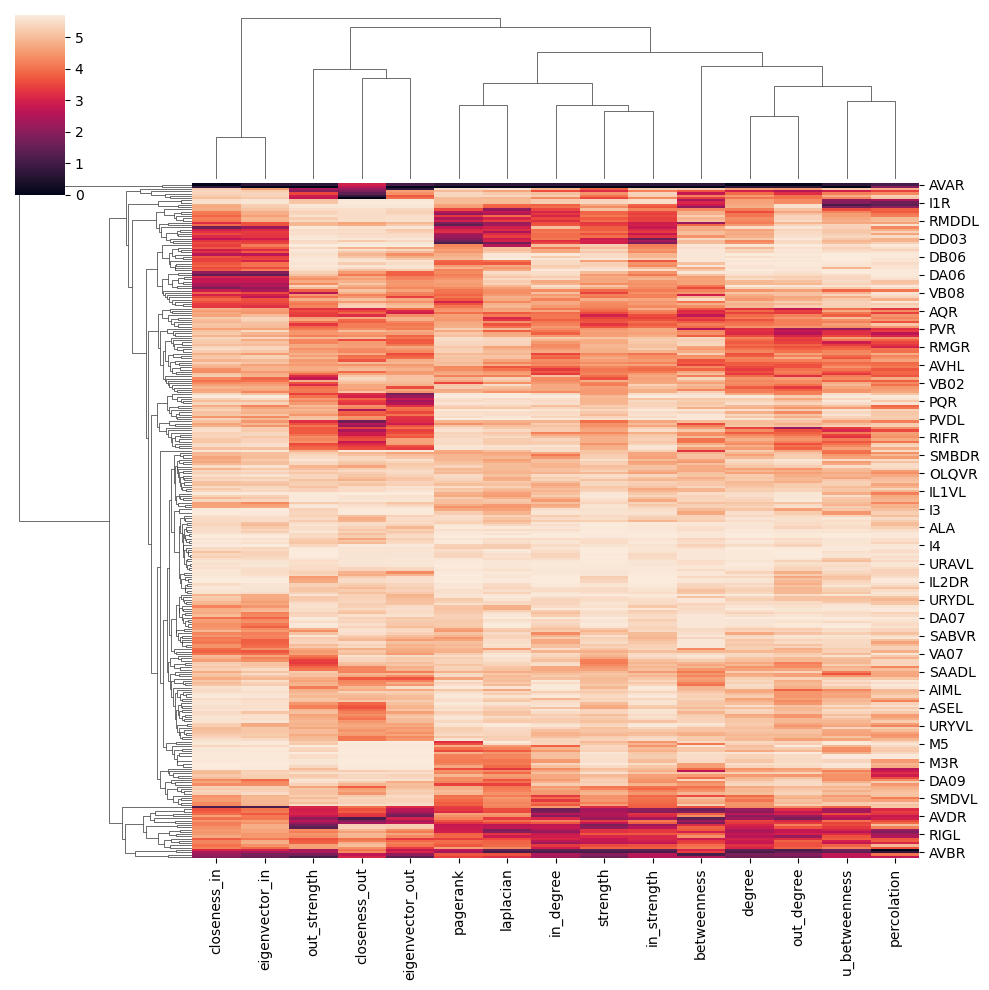

In [209]:
sns.clustermap(df_to_cluster, method='average', metric='euclidean')

# Karate club:


In [102]:
karate_g = nx.karate_club_graph()

slice_string = ['pre', 'post']
w_str = None
iw_str = None
karate_g.edges(data=True)

EdgeDataView([(0, 1, {'weight': 4}), (0, 2, {'weight': 5}), (0, 3, {'weight': 3}), (0, 4, {'weight': 3}), (0, 5, {'weight': 3}), (0, 6, {'weight': 3}), (0, 7, {'weight': 2}), (0, 8, {'weight': 2}), (0, 10, {'weight': 2}), (0, 11, {'weight': 3}), (0, 12, {'weight': 1}), (0, 13, {'weight': 3}), (0, 17, {'weight': 2}), (0, 19, {'weight': 2}), (0, 21, {'weight': 2}), (0, 31, {'weight': 2}), (1, 2, {'weight': 6}), (1, 3, {'weight': 3}), (1, 7, {'weight': 4}), (1, 13, {'weight': 5}), (1, 17, {'weight': 1}), (1, 19, {'weight': 2}), (1, 21, {'weight': 2}), (1, 30, {'weight': 2}), (2, 3, {'weight': 3}), (2, 7, {'weight': 4}), (2, 8, {'weight': 5}), (2, 9, {'weight': 1}), (2, 13, {'weight': 3}), (2, 27, {'weight': 2}), (2, 28, {'weight': 2}), (2, 32, {'weight': 2}), (3, 7, {'weight': 3}), (3, 12, {'weight': 3}), (3, 13, {'weight': 3}), (4, 6, {'weight': 2}), (4, 10, {'weight': 3}), (5, 6, {'weight': 5}), (5, 10, {'weight': 3}), (5, 16, {'weight': 3}), (6, 16, {'weight': 3}), (8, 30, {'weight': 3

In [152]:
ccent = nx.closeness_centrality(karate_g, distance=None) 
deg_cent = nx.degree_centrality(karate_g)
bcent = nx.betweenness_centrality(karate_g, weight=None)

cf_bcent = nx.current_flow_betweenness_centrality(karate_g, weight=None)
ecent = nx.eigenvector_centrality(karate_g, weight=None)
laplacian = nx.laplacian_centrality(karate_g, weight=w_str)
pagerank = nx.pagerank(karate_g)
harmonic = nx.harmonic_centrality(karate_g)
katz = nx.katz_centrality(karate_g)
# katz_in = nx.katz_centrality(karate_g.)

# percolation = nx.percolation_centrality(karate_g)

centralities = {'cf_betweenness':cf_bcent,
                # 'eigenvector':ecent,
                'degree':deg_cent, 
                # 'laplacian':laplacian,
                'pagerank':pagerank, 
                # 'percolation':percolation, 
                'harmonic': harmonic}
c_df = pd.DataFrame(centralities)


In [153]:
# # rescale these by ranking and taking the log of the ranking 
# rank_karate_centralities =c_df.copy(True)

# to_rank_cols = rank_karate_centralities.columns

# for i in to_rank_cols:
#     rank_karate_centralities[i] = np.log(rank_karate_centralities[i].rank(ascending=False, method='average'))


# df_to_cluster = rank_karate_centralities
# exclude = []  # exclude the ones that are not centralities
# cents_for_clustering = set(df_to_cluster.columns) - set(exclude)

# df_to_cluster_cent = df_to_cluster.loc[:, list(cents_for_clustering)]
# ind_to_id = df_to_cluster_cent.index.values
# # specify_label_dict = id_to_ctype
# method='ward'
# metric='euclidean'
# Z = linkage(df_to_cluster_cent, method=method, metric=metric) ####### linkage

# cut = 0.3
# t = max(Z[:,2]) * cut
# clusteroutput = fcluster(Z, t=t, criterion='distance')
# clusterlen = set(clusteroutput)
# cmap = mpl.colormaps['tab10']

# clustercmap = {int(val) : to_hex(cmap(ind)) for ind, val in enumerate(list(clusterlen))}
# assignment = dict(zip(karate_g.nodes(), clusteroutput))
# partition = [[node for node, val in assignment.items() if val==cl] for cl in list(clusterlen)]
# leaf_to_color = {i:clustercmap.get(clusteroutput[ind]) for ind, i in enumerate(karate_g.nodes())}
# link_cols = {}
# for i, i12 in enumerate(Z[:,:2].astype(int)):
#     c1, c2 = (link_cols[x] if x > len(Z) else to_hex(leaf_to_color[ind_to_id[x]])
#         for x in i12)
#     link_cols[i+1+len(Z)] = c1 if c1 == c2 else 'black'


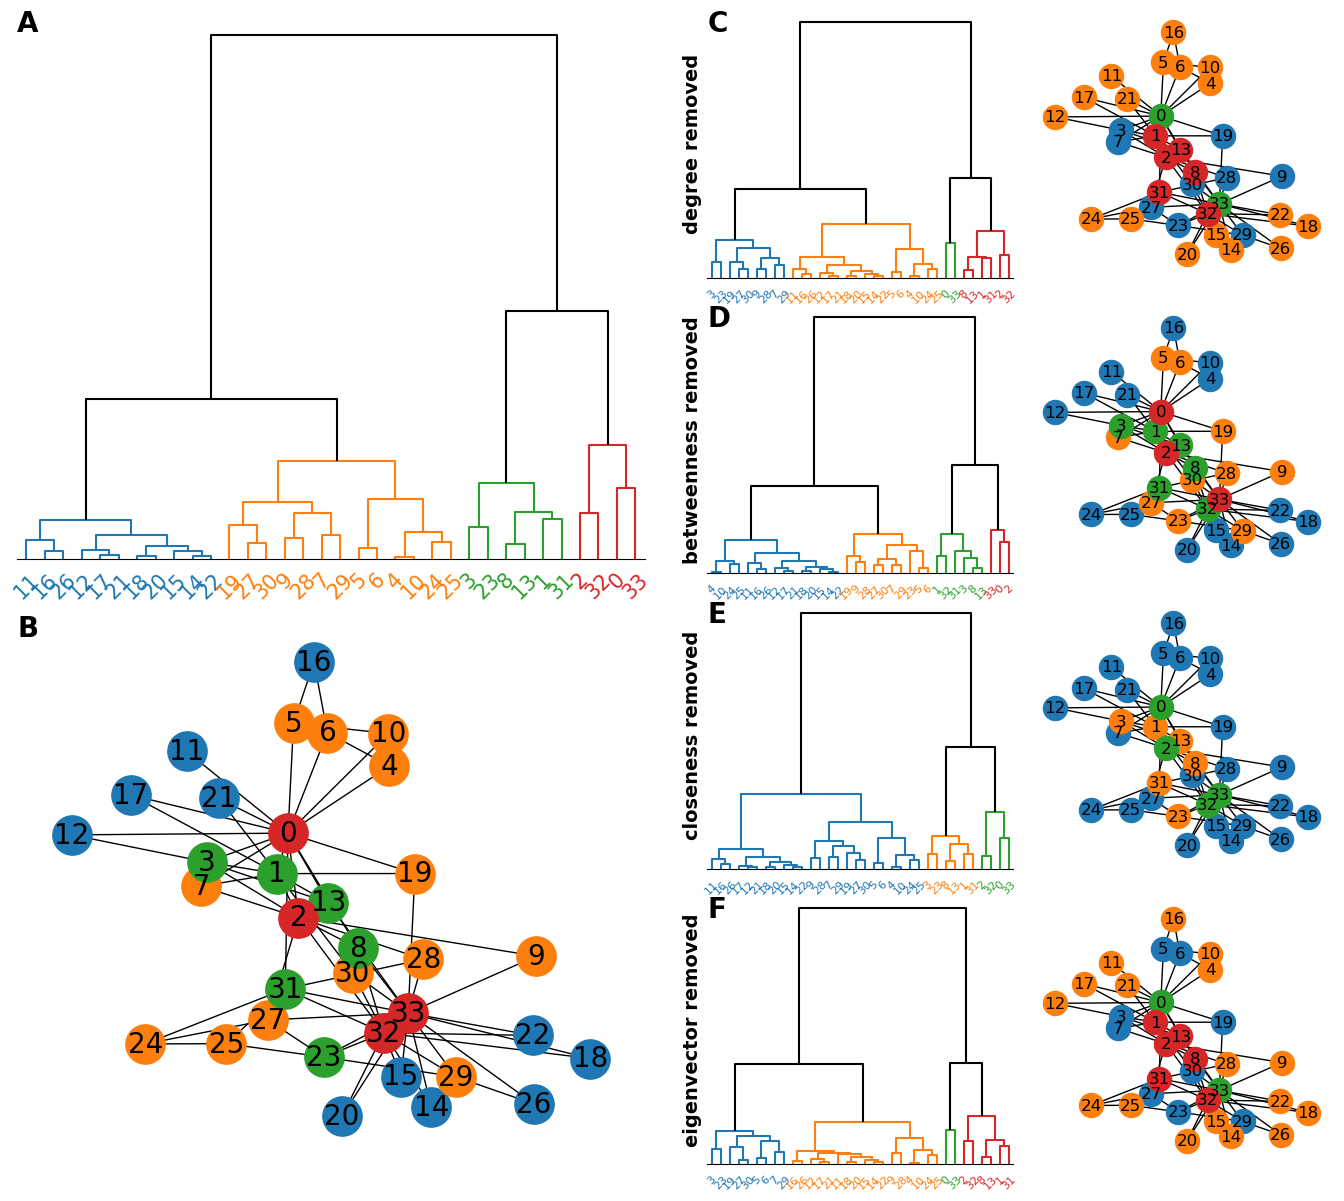

In [154]:
exclude = []  # exclude the ones that are not centralities

fig = plt.figure(figsize=(17, 15))
gs0 = GridSpec(1,2, figure=fig, width_ratios=[1,1], wspace=0.1)
gs1 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0], height_ratios=[1,1], hspace=0.1)
gs2 = GridSpecFromSubplotSpec(4,2, subplot_spec=gs0[1], width_ratios=[1,1], wspace=0.05, height_ratios=[1 for _ in range(4)], hspace=0.1)

cmap = mpl.colormaps['tab10']

dend_ax = fig.add_subplot(gs1[0])
graph_ax = fig.add_subplot(gs1[1])
cents_for_clustering = set(df_to_cluster.columns)

df_to_cluster_cent = df_to_cluster.loc[:, list(cents_for_clustering)]
ind_to_id = df_to_cluster_cent.index.values
# specify_label_dict = id_to_ctype
method='ward'
metric='euclidean'
Z = linkage(df_to_cluster_cent, method=method, metric=metric) ####### linkage
# title = f'Karate club centrality clustering, method={method}'
# dendrogram_clustering(Z=Z, labels=ind_to_id, clusters=[[None]], label_dict=False, title_str=f'{title}')
cut = 0.3
t = max(Z[:,2]) * cut
clusteroutput = fcluster(Z, t=t, criterion='distance')
clusterlen = set(clusteroutput)
assignment = dict(zip(karate_g.nodes(), clusteroutput))
partition = [[node for node, val in assignment.items() if val==cl] for cl in list(clusterlen)]
# plt.figure(figsize=(5,5))
pos = nx.spring_layout(karate_g, seed=0)
clustercmap = {int(val) : to_hex(cmap(ind)) for ind, val in enumerate(list(clusterlen))}
leaf_to_color = {i:clustercmap.get(clusteroutput[ind]) for ind, i in enumerate(karate_g.nodes())}
for ind, nodelist in enumerate(partition):
    nx.draw_networkx_nodes(karate_g, nodelist=nodelist, node_color=clustercmap.get(int(ind)+1), pos=pos, ax=graph_ax, node_size=800)
nx.draw_networkx_edges(karate_g, pos=pos, ax=graph_ax)
nx.draw_networkx_labels(karate_g, pos, ax=graph_ax, font_size=20)
graph_ax.axis('off')

link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
    c1, c2 = (link_cols[x] if x > len(Z) else to_hex(leaf_to_color[ind_to_id[x]])
        for x in i12)
    link_cols[i+1+len(Z)] = c1 if c1 == c2 else 'black'

col_dendrogram = dendrogram(Z, color_threshold=0, above_threshold_color='black', ax=dend_ax, labels=ind_to_id, link_color_func=lambda x: link_cols[x])
# ax_col_dendrogram.set_axis_off()
# dend_ax # make x axis labels larger
dend_ax.tick_params(axis='x', labelsize=15)
ylbls = dend_ax.get_xmajorticklabels()
for i in range(len(partition)):
    clstr = partition[i]
    # print(clstr)
    for lbl in ylbls:
        
        label_colors = {'True' : clustercmap[i+1], 'False' : 'black'}

        is_clstr = int(lbl.get_text()) in clstr
        # print(lbl.get_text())
        if is_clstr:
            lbl.set_color(label_colors[str(is_clstr)])

# dend_ax.set_xlabel
dend_ax.set_yticks([])
dend_ax.spines['left'].set_visible(False)
dend_ax.spines['top'].set_visible(False)
dend_ax.spines['right'].set_visible(False)
# dend_ax.set_ylabel(f'{term} removed', fontsize=14)
dend_ax.text(0, 1, 'A', transform=dend_ax.transAxes, fontsize=20, fontweight='bold', va='top',  ha='left')
graph_ax.text(0, 1, 'B', transform=graph_ax.transAxes, fontsize=20, fontweight='bold', va='top',  ha='left')
# dend_ax.text(0, 1, 'B', transform=dend_ax.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')

# dend_ax.text(0, 1, 'C', transform=dend_ax.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')




subfig = 'CDEFGH'

for row_ind, term in enumerate(['degree', 'betweenness', 'closeness', 'eigenvector']):
    dend_ax = fig.add_subplot(gs2[row_ind, 0])
    graph_ax = fig.add_subplot(gs2[row_ind, 1])
    # print(term)
    cents_for_clustering = set(df_to_cluster.columns) - set([term])

    df_to_cluster_cent = df_to_cluster.loc[:, list(cents_for_clustering)]
    ind_to_id = df_to_cluster_cent.index.values
    # specify_label_dict = id_to_ctype
    method='ward'
    metric='euclidean'
    Z = linkage(df_to_cluster_cent, method=method, metric=metric) ####### linkage
    title = f'Karate club centrality clustering, method={method}'
    # dendrogram_clustering(Z=Z, labels=ind_to_id, clusters=[[None]], label_dict=False, title_str=f'{title}')
    cut = 0.3
    t = max(Z[:,2]) * cut
    clusteroutput = fcluster(Z, t=t, criterion='distance')
    clusterlen = set(clusteroutput)
    assignment = dict(zip(karate_g.nodes(), clusteroutput))
    partition = [[node for node, val in assignment.items() if val==cl] for cl in list(clusterlen)]
    # plt.figure(figsize=(5,5))
    pos = nx.spring_layout(karate_g, seed=0)
    clustercmap = {int(val) : to_hex(cmap(ind)) for ind, val in enumerate(list(clusterlen))}
    leaf_to_color = {i:clustercmap.get(clusteroutput[ind]) for ind, i in enumerate(karate_g.nodes())}
    for ind, nodelist in enumerate(partition):
        nx.draw_networkx_nodes(karate_g, nodelist=nodelist, node_color=clustercmap.get(int(ind)+1), pos=pos, ax=graph_ax)
    nx.draw_networkx_edges(karate_g, pos=pos, ax=graph_ax)
    nx.draw_networkx_labels(karate_g, pos, ax=graph_ax)
    graph_ax.axis('off')

    link_cols = {}
    for i, i12 in enumerate(Z[:,:2].astype(int)):
        c1, c2 = (link_cols[x] if x > len(Z) else to_hex(leaf_to_color[ind_to_id[x]])
            for x in i12)
        link_cols[i+1+len(Z)] = c1 if c1 == c2 else 'black'

    col_dendrogram = dendrogram(Z, color_threshold=0, above_threshold_color='black', ax=dend_ax, labels=ind_to_id, link_color_func=lambda x: link_cols[x])
    # ax_col_dendrogram.set_axis_off()
    ylbls = dend_ax.get_xmajorticklabels()
    for i in range(len(partition)):
        clstr = partition[i]
        # print(clstr)
        for lbl in ylbls:
            
            label_colors = {'True' : clustercmap[i+1], 'False' : 'black'}

            is_clstr = int(lbl.get_text()) in clstr
            # print(lbl.get_text())
            if is_clstr:
                lbl.set_color(label_colors[str(is_clstr)])

    # dend_ax.set_xlabel
    dend_ax.set_yticks([])
    dend_ax.spines['left'].set_visible(False)
    dend_ax.spines['top'].set_visible(False)
    dend_ax.spines['right'].set_visible(False)
    dend_ax.set_ylabel(f'{term} removed', fontsize=14, fontweight='bold')
    dend_ax.text(0, 1, subfig[row_ind], transform=dend_ax.transAxes, fontsize=20, fontweight='bold', va='top',  ha='left')
    # dend_ax.text(0, 1, 'B', transform=dend_ax.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')
    # dend_ax.text(0, 1, 'C', transform=dend_ax.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')

save_things = False
if save_things:
    plt.savefig(f'../figures/karate_clustering_abl.pdf', bbox_inches='tight', transparent=True)
    plt.savefig(f'../figures/karate_clustering_abl.png', bbox_inches='tight', transparent=True)
plt.show()



In [155]:
c_df

,cf_betweenness,degree,pagerank,harmonic
0,0.486387,0.484848,0.088508,23.166667
1,0.183764,0.272727,0.057415,19.166667
2,0.252738,0.303030,0.062767,21.000000
3,0.099877,0.181818,0.037212,17.666667
4,0.046900,0.090909,0.020504,14.666667
5,0.071787,0.121212,0.033810,15.166667
6,0.071787,0.121212,0.031529,15.166667
7,0.053562,0.121212,0.026465,16.416667
8,0.103536,0.151515,0.033382,18.500000
9,0.029126,0.060606,0.009463,15.583333


In [156]:


# rescale these by ranking and taking the log of the ranking 
rank_karate_centralities =c_df.copy(True)
# rank_karate_centralities = rank_karate_centralities.loc[:,[]]
to_rank_cols = rank_karate_centralities.columns

for i in to_rank_cols:
    rank_karate_centralities[i] = np.log(rank_karate_centralities[i].rank(ascending=False, method='average'))


df_to_cluster = rank_karate_centralities
exclude = ["closeness",]  # exclude the ones that are not centralities
# exclude = ["closeness", "percolation"]  # exclude the ones that are not centralities

cents_for_clustering = set(df_to_cluster.columns) - set(exclude)

df_to_cluster_cent = df_to_cluster.loc[:, list(cents_for_clustering)]
ind_to_id = df_to_cluster_cent.index.values
# specify_label_dict = id_to_ctype
method='ward'
metric='euclidean'
Z = linkage(df_to_cluster_cent, method=method, metric=metric) ####### linkage

cut = 0.3
t = max(Z[:,2]) * cut
clusteroutput = fcluster(Z, t=t, criterion='distance')
clusterlen = set(clusteroutput)
cmap = mpl.colormaps['tab10']

clustercmap = {int(val) : to_hex(cmap(ind)) for ind, val in enumerate(list(clusterlen))}
assignment = dict(zip(karate_g.nodes(), clusteroutput))
partition = [[node for node, val in assignment.items() if val==cl] for cl in list(clusterlen)]
leaf_to_color = {i:clustercmap.get(clusteroutput[ind]) for ind, i in enumerate(karate_g.nodes())}
link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
    c1, c2 = (link_cols[x] if x > len(Z) else to_hex(leaf_to_color[ind_to_id[x]])
        for x in i12)
    link_cols[i+1+len(Z)] = c1 if c1 == c2 else 'black'


[11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 26]
[4, 5, 6, 7, 9, 10, 19, 24, 25, 27, 28, 29, 30]
[0, 33]
[1, 2, 3, 8, 13, 23, 31, 32]


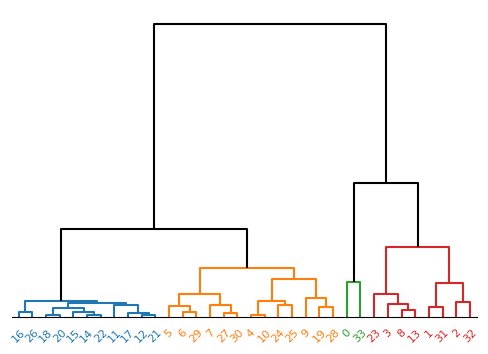

In [157]:
fig, ax_col_dendrogram = plt.subplots(figsize=(6, 4))
col_dendrogram = dendrogram(Z, color_threshold=0, above_threshold_color='black', ax=ax_col_dendrogram, labels=ind_to_id, link_color_func=lambda x: link_cols[x])
# ax_col_dendrogram.set_axis_off()
ylbls = ax_col_dendrogram.get_xmajorticklabels()
for i in range(len(partition)):
    clstr = partition[i]
    print(clstr)
    for lbl in ylbls:
        
        label_colors = {'True' : clustercmap[i+1], 'False' : 'black'}

        is_clstr = int(lbl.get_text()) in clstr
        # print(lbl.get_text())
        if is_clstr:
            lbl.set_color(label_colors[str(is_clstr)])

ax_col_dendrogram.set_xlabel
ax_col_dendrogram.yaxis.set_visible(False)
ax_col_dendrogram.spines['left'].set_visible(False)
ax_col_dendrogram.spines['top'].set_visible(False)
ax_col_dendrogram.spines['right'].set_visible(False)

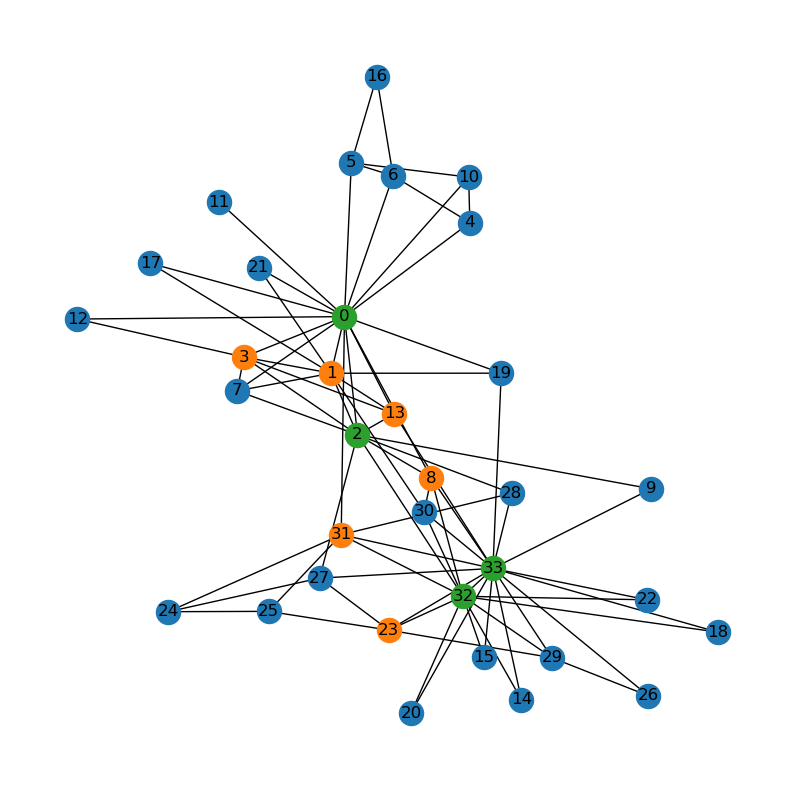

In [142]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(karate_g, seed=0)
# nx.draw(karate_g, pos=pos)
# colors = ['blue', '']
plt.axis('off')
for ind, nodelist in enumerate(partition):
    nx.draw_networkx_nodes(karate_g, nodelist=nodelist, node_color=clustercmap.get(int(ind)+1), pos=pos)
nx.draw_networkx_edges(karate_g, pos=pos)
nx.draw_networkx_labels(karate_g, pos)
plt.show()


In [143]:

df_nodes = pd.DataFrame.from_dict(
    dict(karate_g.nodes(data=True)),
    orient="index"
)

In [144]:
X = df_to_cluster_cent.to_numpy()
y = df_nodes.club.values

In [145]:
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

In [146]:
# # --- 3D plot ---
# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111)

# colors = ['r', 'b', ]
# labels = list(set(y))

# for i, color in enumerate(colors):
#     ax.scatter(X_lda[y==labels[i], 0], X_lda[y==labels[i], 1], 
#                c=color, label=labels[i], s=50, alpha=0.7)

# ax.set_xlabel('LD1')
# ax.set_ylabel('LD2')
# # ax.set_zlabel('LD3')
# ax.set_title('4 Clusters Projected by LDA (3D)')
# ax.legend()
# plt.show()

In [147]:
labels

['Mr. Hi', 'Officer']

In [148]:
print("Shape of components:", lda.scalings_.shape)  # (n_features, n_components)
lda_directions = lda.scalings_

Shape of components: (6, 1)


In [149]:
feature_importance = np.sum(np.abs(lda_directions), axis=1)

In [150]:
# rank features
ranking = np.argsort(feature_importance)[::-1]  # descending

In [151]:
df_to_cluster_cent.columns[ranking]

Index(['cf_betweenness', 'betweenness', 'degree', 'eigenvector', 'pagerank',
       'harmonic'],
      dtype='object')

In [126]:
print("Explained discriminative power:", lda.explained_variance_ratio_)

Explained discriminative power: [1.]


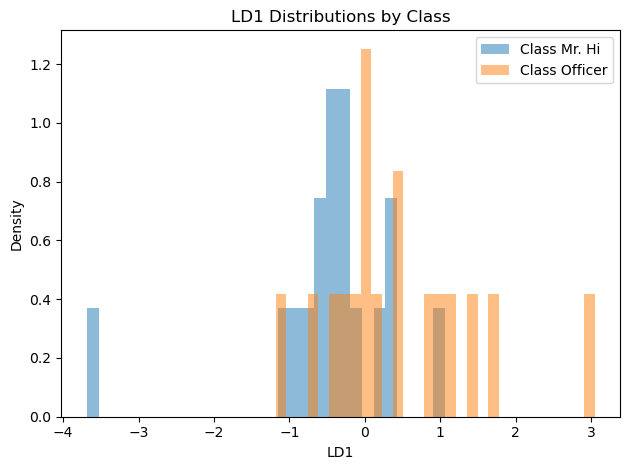

In [128]:
classes = np.unique(y)
for cls in classes:
    plt.hist(
        X_lda[y == cls],
        bins=30,
        density=True,
        alpha=0.5,
        label=f"Class {cls}"
    )

plt.xlabel("LD1")
plt.ylabel("Density")
plt.title("LD1 Distributions by Class")
plt.legend()
plt.tight_layout()
plt.show()